# Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import cufflinks as cf; cf.go_offline()

### Missing values

In [125]:
df = pd.read_feather('removed_duplicated_columns.feather')

In [4]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

In [5]:
missing_percentage.describe()

count    767.000000
mean       9.748255
std       27.342555
min        0.000000
25%        0.002203
50%        0.005507
75%        0.011015
max       99.998899
dtype: float64

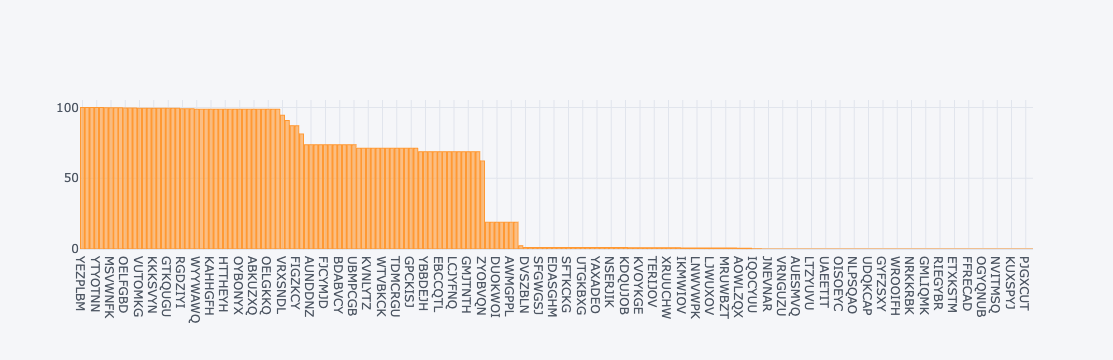

In [6]:
missing_percentage.sort_values(ascending=False).head(200).iplot(kind='bar')

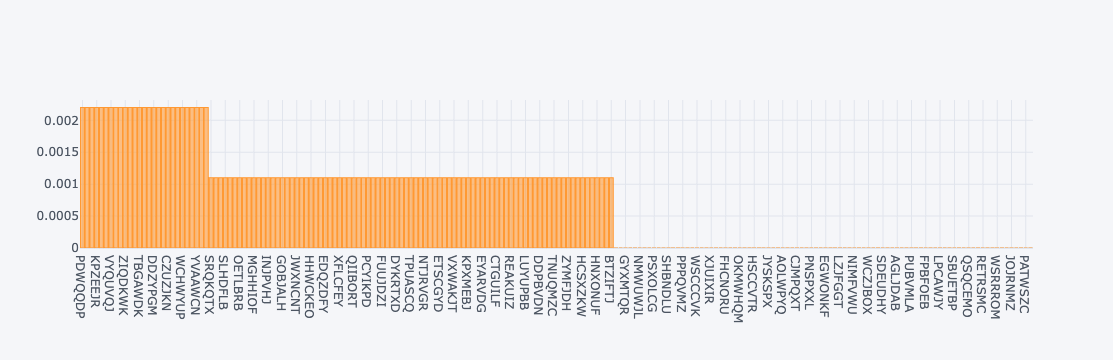

In [7]:
missing_percentage.sort_values(ascending=False).tail(200).iplot(kind='bar')

### Unique values

In [8]:
df.nunique().describe()

count       767.000000
mean      21589.122555
std      111197.579277
min           1.000000
25%          14.000000
50%          81.000000
75%         331.000000
max      723293.000000
dtype: float64

### Target analysis

In [9]:
target_test = 'TLJYWBE'
failure_thd = 1e-5
target_test_col = df[target_test]

In [10]:
target_test_col.isna().sum()

16770

In [11]:
(target_test_col >= failure_thd).value_counts()

False    726224
True         64
Name: TLJYWBE, dtype: int64

### Correlations

In [12]:
sample_for_corr_calc = df.sample(frac=0.1, random_state=42)

In [13]:
valid_cols = missing_percentage[missing_percentage < 50].index
dtypes = df.dtypes
float_cols = [c for c in dtypes[dtypes == 'float64'].index.tolist() if c in valid_cols]
len(float_cols)

658

In [14]:
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

ddf = dd.from_pandas(sample_for_corr_calc, npartitions=8)

with ProgressBar():
    correlation_matrix = ddf[float_cols].corr().compute()

[########################################] | 100% Completed |  2min 30.5s


In [56]:
melted_corr = correlation_matrix.stack().reset_index()
melted_corr.columns = ['col1', 'col2', 'correlation']
melted_corr.correlation = abs(melted_corr.correlation)
melted_corr = melted_corr[melted_corr['col1'] != melted_corr['col2']]

In [57]:
melted_corr = melted_corr.sort_values(by='correlation', ascending=False)
melted_corr.head(50)

,col1,col2,correlation
74691,IFZDTPK,CXQMCRY,1.000000
74049,CXQMCRY,IFZDTPK,1.000000
106824,JNEVNAR,RZPQSGM,1.000000
106182,RZPQSGM,JNEVNAR,1.000000
70185,LTCKGYN,HHWCKEO,1.000000
70827,HHWCKEO,LTCKGYN,1.000000
72761,JMPVBOV,SLHDFLB,1.000000
73403,SLHDFLB,JMPVBOV,1.000000
71473,INJPVHJ,LVMHJCI,1.000000
72115,LVMHJCI,INJPVHJ,1.000000


In [80]:
highly_correlated = melted_corr[melted_corr.correlation > 0.8]
highly_correlated.shape

(6344, 3)

In [84]:
candidates_to_drop = set(highly_correlated.col1.values).union(set(highly_correlated.col2.values))
len(candidates_to_drop)

440

In [86]:
cols_duplicates = []
for cand_col in candidates_to_drop:
    subset = highly_correlated[highly_correlated.col1 == cand_col]
    n_duplicates, duplicates = len(subset), subset.col2.values.tolist()
    cols_duplicates.append((cand_col, n_duplicates, duplicates))    

In [97]:
sorted_cols_duplicates = sorted(cols_duplicates, key=lambda x: -x[1])

In [98]:
sorted_cols_duplicates[-5:]

[('HIPZTCK', 1, ['XQGPAIG']),
 ('JMFGDPB', 1, ['AWMGPPL']),
 ('BKSGEBR', 1, ['EEIRTMR']),
 ('FTMZZVG', 1, ['VTLKBMI']),
 ('DCDCWXQ', 1, ['JNYELDJ'])]

In [121]:
removed = set()
tmp = highly_correlated.copy()
for col, _, duplicates in sorted_cols_duplicates:
    if not col in tmp.col1.values:
        continue
    tmp = tmp[~tmp.col1.isin(duplicates)]
    removed.update(duplicates)
    print(f'Size dataframe: {len(tmp)} (Started at {len(highly_correlated)}. Unique columns remained: {tmp.col1.nunique()},  unique columns remodevd: {len(removed)}')
    

Size dataframe: 3077 (Started at 6344. Unique columns remained: 376,  unique columns remodevd: 64
Size dataframe: 2171 (Started at 6344. Unique columns remained: 344,  unique columns remodevd: 96
Size dataframe: 1593 (Started at 6344. Unique columns remained: 317,  unique columns remodevd: 123
Size dataframe: 1559 (Started at 6344. Unique columns remained: 315,  unique columns remodevd: 125
Size dataframe: 1513 (Started at 6344. Unique columns remained: 312,  unique columns remodevd: 128
Size dataframe: 1479 (Started at 6344. Unique columns remained: 310,  unique columns remodevd: 130
Size dataframe: 1389 (Started at 6344. Unique columns remained: 303,  unique columns remodevd: 137
Size dataframe: 1359 (Started at 6344. Unique columns remained: 301,  unique columns remodevd: 139
Size dataframe: 1190 (Started at 6344. Unique columns remained: 288,  unique columns remodevd: 152
Size dataframe: 1172 (Started at 6344. Unique columns remained: 286,  unique columns remodevd: 154
Size datafra

In [122]:
highly_correlated.col1.nunique()

440

In [123]:
tmp.col1.nunique() + len(set(removed))

440

## Removing highly correlated columns:

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726288 entries, 0 to 726287
Columns: 767 entries, HKTLMYY to TLJYWBE
dtypes: float64(742), int64(21), object(4)
memory usage: 4.2+ GB


In [129]:
updated_df = df.drop(columns=removed)
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726288 entries, 0 to 726287
Columns: 420 entries, HKTLMYY to TLJYWBE
dtypes: float64(395), int64(21), object(4)
memory usage: 2.3+ GB


In [131]:
updated_df.to_feather('dataset_no_duplicates_no_univalue_no_correlated_columns.feather')